In [43]:
!pip install -q kaggle


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import glob

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.preprocessing import image as tf_img


In [45]:
from google.colab import files

In [46]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"daya07","key":"855ccb8483bcd2c583ba56dd2043e35f"}'}

In [47]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [48]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              222KB  2021-04-03 08:45:43           1646  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1090  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            865  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19            384  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [49]:
!kaggle datasets download -d biaiscience/dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [50]:
!ls

 dogs-vs-cats.zip  'kaggle (1).json'   kaggle.json   sample_data   test   train


In [51]:
!unzip 'dogs-vs-cats.zip'

Archive:  dogs-vs-cats.zip
replace test/test/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [53]:
!cd train

In [54]:
!ls

 dogs-vs-cats.zip  'kaggle (1).json'   kaggle.json   sample_data   test   train


In [62]:
import glob
img_path=[]
image_name=[]
object_name=[]
label=[]
for file in glob.glob('/content/train/train/*'):
  img_path.append(file)
  name=str(file.split('/')[4])
  image_name.append(name)
  obj_name=str(name.split('.')[0])
  object_name.append(obj_name)
  if(obj_name=='cat'):
    label.append(0)
  else:
    label.append(1)
  

In [63]:
len(image_name)

25000

In [64]:
# Let's create an dataframe

data=pd.DataFrame()

data['Path']=img_path
data['Name']=image_name
data['Object']=object_name
data['label']=label

data.head()

,Path,Name,Object,label
0,/content/train/train/cat.7191.jpg,cat.7191.jpg,cat,0
1,/content/train/train/cat.5733.jpg,cat.5733.jpg,cat,0
2,/content/train/train/dog.9624.jpg,dog.9624.jpg,dog,1
3,/content/train/train/dog.5069.jpg,dog.5069.jpg,dog,1
4,/content/train/train/dog.8989.jpg,dog.8989.jpg,dog,1


In [65]:
# Let's define some parameters

IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=64

In [89]:

from sklearn.model_selection import train_test_split

data['label']=data['label'].astype('str')
# Splitting the data into train and test 
train_data,test_data=train_test_split(data,stratify=data['label'],test_size=0.08)


'''
train_data.shape
train_data['label']=train_data['label'].astype('str')
test_data['label']=test_data['label'].astype('str')
'''

"\ntrain_data.shape\ntrain_data['label']=train_data['label'].astype('str')\ntest_data['label']=test_data['label'].astype('str')\n"

In [90]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

'''
valid_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2
                    )
                    '''


test_datagen = ImageDataGenerator(rescale = 1./255)

training_set =  train_datagen.flow_from_dataframe(dataframe=train_data,batch_size=BATCH_SIZE,
                                                  x_col='Path',y_col='label',
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')
'''
validation_set=valid_datagen.flow_from_dataframe(dataframe=valid_data,batch_size=BATCH_SIZE,
                                                  x_col='Path',y_col='label',
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')
                                                     '''

test_set = test_datagen.flow_from_dataframe(dataframe=test_data,batch_size=BATCH_SIZE,
                                                     x_col='Path',y_col='label',
                                                     shuffle=True,
                                                     target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                     class_mode='binary')


Found 23000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [91]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers

pre_trained_model = VGG16(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

vggmodel = tf.keras.models.Model(pre_trained_model.input, x)

vggmodel.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

vggmodel.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [98]:
vgghist = vggmodel.fit(
  training_set,
  epochs=20,
  validation_data=validation_set
)

Epoch 1/20
360/360 [==============================] - 152s 422ms/step - loss: 0.5866 - accuracy: 0.6782 - val_loss: 0.4204 - val_accuracy: 0.8165
Epoch 2/20
360/360 [==============================] - 146s 405ms/step - loss: 0.4404 - accuracy: 0.7939 - val_loss: 0.3303 - val_accuracy: 0.8574
Epoch 3/20
360/360 [==============================] - 146s 405ms/step - loss: 0.3879 - accuracy: 0.8232 - val_loss: 0.2998 - val_accuracy: 0.8652
Epoch 4/20
360/360 [==============================] - 146s 405ms/step - loss: 0.3598 - accuracy: 0.8399 - val_loss: 0.2890 - val_accuracy: 0.8761
Epoch 5/20
360/360 [==============================] - 146s 405ms/step - loss: 0.3416 - accuracy: 0.8482 - val_loss: 0.2847 - val_accuracy: 0.8778
Epoch 6/20
360/360 [==============================] - 146s 404ms/step - loss: 0.3265 - accuracy: 0.8575 - val_loss: 0.2618 - val_accuracy: 0.8848
Epoch 7/20
360/360 [==============================] - 146s 405ms/step - loss: 0.3196 - accuracy: 0.8593 - val_loss: 0.2594 -

In [99]:
train_loss=vgghist.history['loss']
cv_loss=vgghist.history['val_loss']

train_acc=vgghist.history['accuracy']
cv_acc=vgghist.history['val_accuracy']


In [100]:
# printing a table depicting the detail about the trained model
log_frame = pd.DataFrame(columns = ["Epoch", "Train_Loss", "Train_Accuracy", "CV_Loss", "CV_Accuracy"])
log_frame["Epoch"] = list(range(1,21)) # we have 20 epochs started from 1 
log_frame["Train_Loss"] = train_loss
log_frame["Train_Accuracy"] = train_acc
log_frame["CV_Loss"] = cv_loss
log_frame["CV_Accuracy"] = cv_acc 
log_frame

,Epoch,Train_Loss,Train_Accuracy,CV_Loss,CV_Accuracy
0,1,0.586632,0.678217,0.420429,0.816522
1,2,0.440384,0.793913,0.330311,0.857391
2,3,0.387884,0.823217,0.299836,0.865217
3,4,0.359825,0.839913,0.288961,0.876087
4,5,0.341594,0.848217,0.284695,0.877826
5,6,0.326548,0.857478,0.261810,0.884783
6,7,0.319610,0.859304,0.259430,0.893043
7,8,0.308532,0.864478,0.238685,0.901304
8,9,0.295655,0.871870,0.229548,0.903478
9,10,0.295059,0.872043,0.232624,0.903478


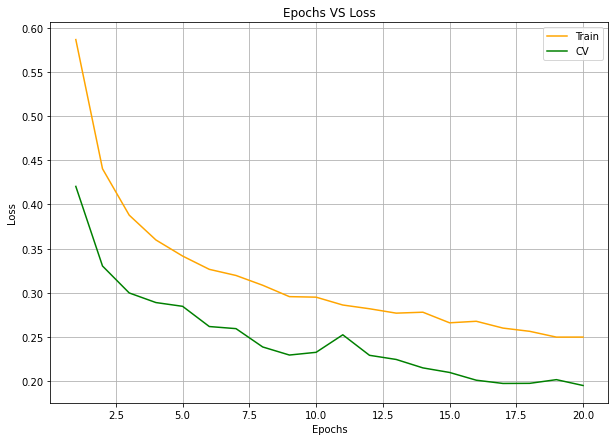

In [101]:
# Plotting Epochs vs Loss

def plotting(epoch,train_los,val_los):
    plt.figure(figsize=(10,7))
    plt.plot(epoch,train_los,color='orange',label='Train')
    plt.plot(epoch,val_los,color='green',label='CV')
    plt.grid()
    plt.title("Epochs VS Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plotting(log_frame['Epoch'],log_frame['Train_Loss'],log_frame['CV_Loss'])

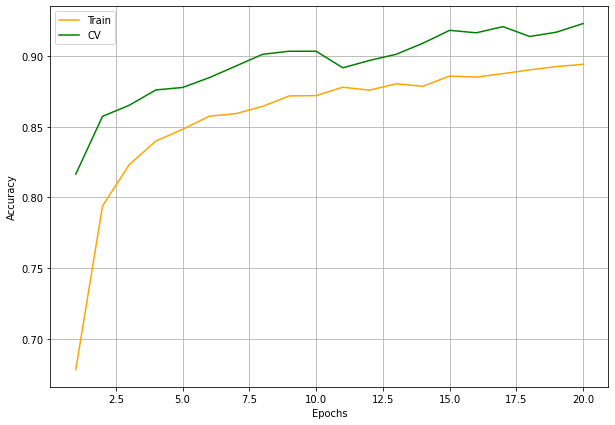

In [102]:
# Plotting Epoch Vs Accuracy

def plot_acc(epoch,train_ac,val_ac):
    plt.figure(figsize=(10,7))
    plt.plot(epoch,train_ac,color='orange',label='Train')
    plt.plot(epoch,val_ac,color='green',label='CV')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    
plot_acc(log_frame['Epoch'],log_frame['Train_Accuracy'],log_frame['CV_Accuracy'])